# Analysis of German Credit Data

## Package imports and settings

In [66]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import scipy
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tikzplotlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import data

In [67]:
data = pd.read_csv('../data/german_credit.csv')
data = data.apply(pd.to_numeric)

## Shuffle data

In [68]:
data = data.sample(frac=1, random_state=4).reset_index(drop=True)

## Change column names

In [69]:
data = data.rename(columns={"Creditability": "classification", "Account Balance": "existingchecking", "Duration of Credit (month)": "duration", "Payment Status of Previous Credit": "credithistory", "Purpose": "purpose", "Credit Amount": "creditamount", "Value Savings/Stocks": "savings", "Length of current employment": "employmentsince", "Instalment per cent": "installmentrate", "Sex & Marital Status": "statussex", "Guarantors": "otherdebtors", "Duration in Current address": "residencesince", "Most valuable available asset": "property", "Age (years)": "age", "Concurrent Credits": "otherinstallmentplans", "Type of apartment": "housing", "No of Credits at this Bank": "existingcredits", "Occupation": "job", "No of dependents": "peopleliable", "Telephone": "telephone", "Foreign Worker": "foreignworker"})

In [70]:
data.head()

,classification,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,residencesince,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker
0,1,2,45,4,1,4576,2,1,3,3,1,4,3,27,3,2,1,3,1,1,1
1,0,1,12,2,6,684,1,3,4,3,1,4,3,40,3,1,1,2,2,1,1
2,0,2,60,2,6,6288,1,3,4,3,1,4,4,42,3,3,1,3,1,1,1
3,0,2,15,0,0,1778,1,2,2,2,1,1,1,26,3,1,2,1,1,1,1
4,0,4,36,2,2,3349,1,3,4,2,1,2,3,28,3,2,1,4,1,2,1


## Variable Explanations

- **classification**: 1 (good credit), 0 (bad credit)
- **existingchecking**: 1 (<0DM), 2 (0<=...<200DM), 3 (>=200DM), 4 (no checking account)
- **duration**: Duration of credit in months
- **credithistory**: 0 (no credits taken/all credits paid back duly), 1 (all credits at this bank paid back duly), 2 (existing credits paid back duly till now), 3 (delay in paying off in the past), 4 (critical account/other credits existing (not at this bank))
- **purpose**: 0 (car new), 1 (car used), 2 (furniture/equipment), 3 (radio/television), 4 (domestic appliances), 5 (repairs), 6 (education), 7 (vacation – does not exist), 8 (retraining), 9 (business), 10 (others)
- **creditamount**: credit amount (in DM)
- **savings**: 1 (<100DM), 2 (100<=...<500DM), 3 (500<=...<1000DM), 4 (>=1000DM), 5 (unknown/no savings account)
- **employmentsince**: 1 (unemployed), 2 (<1 year), 3 (1<=...<4 years), 4 (4<=...<7 years), 5 (>=7 years)
- **installmentrate**: installment rate in percentage of disposable income
- **statussex**: 1 (male divorced/separated), 2 (female divorced/separated/married), 3 (male single), 4 (male married/widowed), 5 (female single – does not exist)
- **otherdebtors**: 1 (none), 2 (co-applicant), 3 (guarantor)
- **residencesince**: present resident since (in years?)
- **property**: 1 (real estate), 2 (if not 1: building society savings agreement/life insurance), 3 (if not 1 or 2: car or other, not in savings attribute), 4 (unknown/no property)
- **age**: age in years
- **otherinstallmentplans**: 1 (bank), 2 (stores), 3 (none)
- **housing**: 1 (rent), 2 (own), 3 (for free)
- **existingcredits**: number of existing credits at this bank
- **job**: 1 (unemployed/unskilled – non-resident), 2 (unskilled – resident), 3 (skilled employee/official), 4 (management/self-employed/highly qualified employee/officer)
- **peopleliable**: number of people being liable to provide maintenance for
- **telephone**: 1 (none), 2 (yes, registered under the customer's name)
- **foreignworker**: 1 (yes), 2 (no)

## Replace values

In order for features to have a monotonic relationship with outcome.

In [71]:
data.existingchecking[data.existingchecking == 4] = 0
data.savings[data.savings == 5] = 0
data.housing[data.housing == 3] = 0

## Separate holdout set

In [72]:
train = data.iloc[:800]
test = data.iloc[800:]

X_train = train.drop("classification",1)
X_test = test.drop("classification",1)
y_train = train["classification"]
y_test = test["classification"]

In [73]:
share_good_test = len(test[test.classification == 1])/len(test)
#print(share_good_test)

## Feature scaling (MinMaxScaler)

In [74]:
col_names = X_train.columns

In [75]:
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

### Truncate test values between 0 and 1

In [76]:
X_test_scaled[X_test_scaled > 1] = 1
X_test_scaled[X_test_scaled < 0] = 0

In [77]:
#X_test_scaled.head()

## Define sensitive (and legitimate) plus irrelevant features

In [78]:
sensitive = ['statussex', 'age', 'foreignworker']
irrelevant = ['duration','purpose', 'installmentrate', 'otherdebtors', 'residencesince', 'otherinstallmentplans', 'existingcredits', 'peopleliable', 'telephone']

In [79]:
X_train_scaled_legit = X_train_scaled.drop(sensitive,1)
X_train_scaled_relevant = X_train_scaled.drop(irrelevant,1)
X_train_scaled_lr = X_train_scaled_legit.drop(irrelevant,1)

X_test_scaled_legit = X_test_scaled.drop(sensitive,1)
X_test_scaled_relevant = X_test_scaled.drop(irrelevant,1)
X_test_scaled_lr = X_test_scaled_legit.drop(irrelevant,1)

In [80]:
#data_irrelevant = data.drop(sensitive,1)
#data_irrelevant = data_irrelevant.drop(X_train_scaled_lr.columns,1)
#data_X_irrelevant = data_irrelevant.drop(["classification","duration"],1)
#len(data_X_irrelevant)-len(data_X_irrelevant.drop_duplicates())

## Feature importance from historical decisions

In [81]:
X_train_scaled_lr_array = X_train_scaled_lr.to_numpy()

### Train RF classifier

Train five random forest classifiers, each with different random state, and compute permutation importance.

In [82]:
imp = list()

for i in range(1,6):
    model = RandomForestClassifier(random_state=i, criterion='gini', oob_score=True, min_samples_leaf=10)
    model.fit(X_train_scaled_lr_array, y_train)
    
    print('Iteration ' + str(i) +':')
    print(model.score(X_train_scaled_lr,y_train)) #Training score
    print(model.score(X_test_scaled_lr,y_test)) #Test score
    print(model.oob_score_) #OOB score
    print('----------')
    
    result = permutation_importance(model, X_train_scaled_lr, y_train, random_state=i, n_repeats = 10)
    #result = permutation_importance(model, X_test_scaled_lr, y_test, random_state=1, n_repeats = 10)
    #sorted_idx = result.importances_mean.argsort()
    
    imp.append(result.importances)

Iteration 1:
0.79125
0.79
0.74375
----------
Iteration 2:
0.7975
0.785
0.7375
----------
Iteration 3:
0.78625
0.785
0.73125
----------
Iteration 4:
0.79875
0.785
0.7375
----------
Iteration 5:
0.79375
0.79
0.7325
----------


### Compute mean and std of feature importance

In [83]:
imp_mean = list()
imp_std = list()
temp = np.zeros(5)

for i in range(0,len(X_train_scaled_lr.columns)):
    for j in range(1,6):
        temp[j-1] = np.mean(imp[j-1][i])
    imp_mean.append(np.mean(temp))
    
temp = list()

for i in range(0,len(X_train_scaled_lr.columns)):
    for j in range(1,6):
        for k in range (0,10):
            temp.append(imp[j-1][i][k])
    imp_std.append(np.std(temp))
    temp = list()

### Have feature importances sum up to 1

In [84]:
factor = 1/np.sum(imp_mean)

print(np.multiply(imp_mean,factor))
print(np.multiply(imp_std,factor))

importance = np.multiply(imp_mean,factor) #Importance of legitimate features in the past

[0.27721162 0.11383348 0.17844753 0.11079792 0.09496964 0.13052905
 0.05832611 0.03588465]
[0.04693174 0.0316075  0.0424037  0.02874801 0.03084036 0.03851083
 0.02513588 0.01816975]


## Dependence of legitimate features and sensitive features

In [85]:
col_names_lr = X_train_scaled_lr.columns

### Absolute Spearman's Rho

In [86]:
def spearmans_rho(data, sensitive, col_names_lr):
    sr = np.zeros((len(sensitive), len(col_names_lr)))
    counter_sens = 0
    counter_lr = 0

    for sens in sensitive:
        for lr in col_names_lr:
            temp = sp.stats.spearmanr(data[sens],data[lr])
            sr[counter_sens][counter_lr] = abs(temp[0])
            counter_lr = counter_lr+1
        counter_lr = 0
        counter_sens = counter_sens+1
        
    return sr

In [87]:
sr = spearmans_rho(train, sensitive, col_names_lr)

### Kendall's Tau

In [88]:
def kendall_tau(data, sensitive, col_names_lr):
    kt = np.zeros((len(sensitive), len(col_names_lr)))
    counter_sens = 0
    counter_lr = 0

    for sens in sensitive:
        for lr in col_names_lr:
            temp = sp.stats.kendalltau(data[sens],data[lr])
            kt[counter_sens][counter_lr] = temp[0]
            counter_lr = counter_lr+1
        counter_lr = 0
        counter_sens = counter_sens+1
        
    return kt

In [89]:
kt = kendall_tau(train, sensitive, col_names_lr)

### Absolute Pearson Correlation

In [90]:
def abs_pearson_correlation(data, sensitive, col_names_lr):
    pc = np.zeros((len(sensitive), len(col_names_lr)))
    counter_sens = 0
    counter_lr = 0

    for sens in sensitive:
        for lr in col_names_lr:
            pc[counter_sens][counter_lr] = abs(data[sens].corr(data[lr]))
            counter_lr = counter_lr+1
        counter_lr = 0
        counter_sens = counter_sens+1
        
    return pc

In [91]:
pc = abs_pearson_correlation(train, sensitive, col_names_lr)

### Plot dependence

In [92]:
barWidth = 0.1

def plot_dependence(pc, sr, kt, barWidth, col_names_lr, sensitive):

    bar_1 = np.arange(len(pc[0][:]))
    bar_2 = [x + barWidth for x in bar_1]
    bar_3 = [x + barWidth for x in bar_2]
    
    for i in range(0,len(sensitive)):
        plt.figure(figsize=(20,5))
        plt.title(sensitive[i])
        
        plt.bar(bar_1, pc[i][:], width=barWidth, label='pc')
        plt.bar(bar_2, sr[i][:], width=barWidth, label='sr')
        plt.bar(bar_3, kt[i][:], width=barWidth, label='kt')

        plt.xticks([r + 2*barWidth for r in range(len(ami[0][:]))], col_names_lr, rotation='vertical')

        plt.legend()
        plt.show()

In [93]:
#plot_dependence(pc, sr, kt, barWidth, col_names_lr, sensitive)

### Compute Spearman's Rho for all legitimate features

In [94]:
dep = np.zeros(len(col_names_lr))

for i in range(0,len(col_names_lr)):
    temp = np.zeros(3)
    temp[0] = sr[0][i]
    temp[1] = sr[1][i]
    temp[2] = sr[2][i]
    dep[i] = np.max(temp)   

In [95]:
dep #Max. Spearman's rank correlation for all legitimate features with any protected feature
dep_neg = [1-x for x in dep]

## Feature Scaling ('more is better')

In [96]:
#X_train_scaled_lr.head()

In [97]:
#Transform features s.t. 1 is always best and 0 is worst
X_train_scaled_lr.iloc[:,1] = 1 - X_train_scaled_lr.iloc[:,1]
X_train_scaled_lr.iloc[:,2] = 1 - X_train_scaled_lr.iloc[:,2]
X_train_scaled_lr.iloc[:,5] = 1 - X_train_scaled_lr.iloc[:,5]

X_test_scaled_lr.iloc[:,1] = 1 - X_test_scaled_lr.iloc[:,1]
X_test_scaled_lr.iloc[:,2] = 1 - X_test_scaled_lr.iloc[:,2]
X_test_scaled_lr.iloc[:,5] = 1 - X_test_scaled_lr.iloc[:,5]

## Learn logistic regression model on all features

In [98]:
logreg = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)

In [99]:
pred_lr_all = logreg.predict(X_test_scaled)

In [100]:
lr_all_prob = logreg.predict_proba(X_test_scaled)

In [101]:
logreg.score(X_test_scaled, y_test)

0.785

In [102]:
#confusion_matrix(y_test, pred_lr_all)

In [103]:
lr_all_prob_good = lr_all_prob.transpose()[1] #Probabilites of good credit for LogReg on all features

## Learn logistic regression model on all but protected features (FTU)

In [104]:
logreg_ftu = LogisticRegression(random_state=0).fit(X_train_scaled_legit, y_train)

In [105]:
pred_lr_ftu = logreg_ftu.predict(X_test_scaled_legit)

In [106]:
lr_ftu_prob = logreg_ftu.predict_proba(X_test_scaled_legit)

In [107]:
logreg_ftu.score(X_test_scaled_legit, y_test)

0.765

In [108]:
#confusion_matrix(y_test, pred_lr_ftu)

In [109]:
lr_ftu_prob_good = lr_ftu_prob.transpose()[1] #Probabilities of good credit for LogReg based on FTU

## Compute distance to the North Star and compute new labels

In [110]:
north_star = np.ones(len(X_test_scaled_lr.columns))

In [111]:
north_star

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [112]:
#Weighted Manhattan Distance
def weightedManhattan(a,b,w):
    q = a-b
    return (w*np.absolute(q)).sum()

In [113]:
temp = list()
X_test_scaled_lr_array = X_test_scaled_lr.to_numpy()

for i in range(0,len(X_test_scaled_lr_array)):
    dist = weightedManhattan(X_test_scaled_lr_array[i], north_star, importance*dep_neg)
    temp.append(dist)
    
dist = temp
dist_neg = [1-x for x in dist]

In [114]:
test_new = X_test.copy()
test_new['NEG_DIST_NORTH_STAR'] = dist_neg
test_new['OUR_RANK'] = test_new['NEG_DIST_NORTH_STAR'].rank(ascending=False).astype(int)

In [115]:
temp = list()
cutoff = math.ceil(len(test_new)*share_good_test)
dist_neg_ordered = test_new['NEG_DIST_NORTH_STAR'].sort_values(ascending=False)
threshold_dist = dist_neg_ordered.iloc[cutoff]

for i in test_new['NEG_DIST_NORTH_STAR']:
    if (i > threshold_dist):
        temp.append(1)
    else:
        temp.append(0)

## Add remaining columns to test data

In [116]:
test_new['LR_ALL_PROB_GOOD'] = lr_all_prob_good
test_new['LR_ALL_RANK'] = test_new['LR_ALL_PROB_GOOD'].rank(ascending=False).astype(int)
#test_new['LR_ALL_LABELS'] = pred_lr_all
test_new['LR_FTU_PROB_GOOD'] = lr_ftu_prob_good
test_new['LR_FTU_RANK'] = test_new['LR_FTU_PROB_GOOD'].rank(ascending=False).astype(int)
#test_new['LR_FTU_LABELS'] = pred_lr_ftu
test_new['ORIGINAL_LABELS'] = y_test

test_new = test_new.reset_index(drop=True)

In [117]:
test_new

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,residencesince,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,NEG_DIST_NORTH_STAR,OUR_RANK,LR_ALL_PROB_GOOD,LR_ALL_RANK,LR_FTU_PROB_GOOD,LR_FTU_RANK,ORIGINAL_LABELS
0,2,36,2,5,2384,1,2,4,3,1,1,4,33,3,1,1,2,1,1,1,0.554945,97,0.323779,192,0.296685,193,0
1,0,14,3,0,802,1,3,4,3,1,2,3,27,3,2,2,2,1,1,1,0.455489,168,0.763962,82,0.759926,87,1
2,2,48,3,6,6224,1,5,4,3,1,4,4,50,3,0,1,3,1,1,1,0.526834,126,0.365097,187,0.325959,190,0
3,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,1,1,1,0.742403,12,0.710147,112,0.752042,92,1
4,0,12,2,2,1574,1,3,4,3,1,2,1,50,3,2,1,3,1,1,1,0.559271,95,0.836967,59,0.810017,68,1
5,2,12,2,0,1007,4,3,4,4,1,1,1,22,3,2,1,3,1,1,1,0.815767,4,0.728186,102,0.670326,124,1
6,3,42,4,1,4796,1,5,4,3,1,4,4,56,3,0,1,3,1,1,1,0.601557,68,0.372253,186,0.328131,189,1
7,0,12,4,0,926,1,1,1,2,1,2,2,38,3,2,1,1,1,1,1,0.425127,184,0.895993,23,0.903439,12,1
8,2,18,2,9,1941,4,3,4,3,1,2,2,35,3,2,1,2,1,2,1,0.758376,7,0.728651,101,0.707091,112,1
9,1,10,4,0,2241,1,2,1,3,1,3,1,48,3,1,2,2,2,1,2,0.536195,118,0.904450,17,0.826791,58,1


## Measure individual unfairness

In [118]:
X_test_scaled_lr_new = X_test_scaled_lr.copy()
#X_test_scaled_lr_new.head()

In [119]:
X_test_scaled_lr_new['LR_ALL_RANK'] = test_new['LR_ALL_RANK']
X_test_scaled_lr_new['LR_FTU_RANK'] = test_new['LR_FTU_RANK']
X_test_scaled_lr_new['OUR_RANK'] = test_new['OUR_RANK']
X_test_scaled_lr_new['ORIGINAL_LABELS'] = test_new['ORIGINAL_LABELS']

In [120]:
#X_test_scaled_lr_new

### Ranking: Share of unfairly treated individuals and overall instances of unfairness

In [121]:
counter_LR_ALL = 0
counter_LR_FTU = 0
counter_OUR_METHOD = 0
counter_ORIGINAL = 0

for i in range(0,len(X_test_scaled_lr)):
    for j in range(0,len(X_test_scaled_lr)):
        if(np.greater_equal(X_test_scaled_lr.iloc[i],X_test_scaled_lr.iloc[j]).all()):
            if(np.greater(X_test_scaled_lr.iloc[i][0],X_test_scaled_lr.iloc[j][0])
               or np.greater(X_test_scaled_lr.iloc[i][1],X_test_scaled_lr.iloc[j][1])
               or np.greater(X_test_scaled_lr.iloc[i][2],X_test_scaled_lr.iloc[j][2])
               or np.greater(X_test_scaled_lr.iloc[i][3],X_test_scaled_lr.iloc[j][3])
               or np.greater(X_test_scaled_lr.iloc[i][4],X_test_scaled_lr.iloc[j][4])
               or np.greater(X_test_scaled_lr.iloc[i][5],X_test_scaled_lr.iloc[j][5])
               or np.greater(X_test_scaled_lr.iloc[i][6],X_test_scaled_lr.iloc[j][6])
               or np.greater(X_test_scaled_lr.iloc[i][7],X_test_scaled_lr.iloc[j][7])
              ):
                if(np.greater(X_test_scaled_lr_new.iloc[i][8],X_test_scaled_lr_new.iloc[j][8])):
                    counter_LR_ALL = counter_LR_ALL+1
                    #break

for i in range(0,len(X_test_scaled_lr)):
    for j in range(0,len(X_test_scaled_lr)):
        if(np.greater_equal(X_test_scaled_lr.iloc[i],X_test_scaled_lr.iloc[j]).all()):
            if(np.greater(X_test_scaled_lr.iloc[i][0],X_test_scaled_lr.iloc[j][0])
               or np.greater(X_test_scaled_lr.iloc[i][1],X_test_scaled_lr.iloc[j][1])
               or np.greater(X_test_scaled_lr.iloc[i][2],X_test_scaled_lr.iloc[j][2])
               or np.greater(X_test_scaled_lr.iloc[i][3],X_test_scaled_lr.iloc[j][3])
               or np.greater(X_test_scaled_lr.iloc[i][4],X_test_scaled_lr.iloc[j][4])
               or np.greater(X_test_scaled_lr.iloc[i][5],X_test_scaled_lr.iloc[j][5])
               or np.greater(X_test_scaled_lr.iloc[i][6],X_test_scaled_lr.iloc[j][6])
               or np.greater(X_test_scaled_lr.iloc[i][7],X_test_scaled_lr.iloc[j][7])
              ):
                if(np.greater(X_test_scaled_lr_new.iloc[i][9],X_test_scaled_lr_new.iloc[j][9])):
                    counter_LR_FTU = counter_LR_FTU+1
                    #break
                    
for i in range(0,len(X_test_scaled_lr)):
    for j in range(0,len(X_test_scaled_lr)):
        if(np.greater_equal(X_test_scaled_lr.iloc[i],X_test_scaled_lr.iloc[j]).all()):
            if(np.greater(X_test_scaled_lr.iloc[i][0],X_test_scaled_lr.iloc[j][0])
               or np.greater(X_test_scaled_lr.iloc[i][1],X_test_scaled_lr.iloc[j][1])
               or np.greater(X_test_scaled_lr.iloc[i][2],X_test_scaled_lr.iloc[j][2])
               or np.greater(X_test_scaled_lr.iloc[i][3],X_test_scaled_lr.iloc[j][3])
               or np.greater(X_test_scaled_lr.iloc[i][4],X_test_scaled_lr.iloc[j][4])
               or np.greater(X_test_scaled_lr.iloc[i][5],X_test_scaled_lr.iloc[j][5])
               or np.greater(X_test_scaled_lr.iloc[i][6],X_test_scaled_lr.iloc[j][6])
               or np.greater(X_test_scaled_lr.iloc[i][7],X_test_scaled_lr.iloc[j][7])
              ):
                if(np.greater(X_test_scaled_lr_new.iloc[i][10],X_test_scaled_lr_new.iloc[j][10])):
                    counter_OUR_METHOD = counter_OUR_METHOD+1
                    #break
                    
for i in range(0,len(X_test_scaled_lr)):
    for j in range(0,len(X_test_scaled_lr)):
        if(np.greater_equal(X_test_scaled_lr.iloc[i],X_test_scaled_lr.iloc[j]).all()):
            if(np.greater(X_test_scaled_lr.iloc[i][0],X_test_scaled_lr.iloc[j][0])
               or np.greater(X_test_scaled_lr.iloc[i][1],X_test_scaled_lr.iloc[j][1])
               or np.greater(X_test_scaled_lr.iloc[i][2],X_test_scaled_lr.iloc[j][2])
               or np.greater(X_test_scaled_lr.iloc[i][3],X_test_scaled_lr.iloc[j][3])
               or np.greater(X_test_scaled_lr.iloc[i][4],X_test_scaled_lr.iloc[j][4])
               or np.greater(X_test_scaled_lr.iloc[i][5],X_test_scaled_lr.iloc[j][5])
               or np.greater(X_test_scaled_lr.iloc[i][6],X_test_scaled_lr.iloc[j][6])
               or np.greater(X_test_scaled_lr.iloc[i][7],X_test_scaled_lr.iloc[j][7])
              ):
                if(np.less(X_test_scaled_lr_new.iloc[i][11],X_test_scaled_lr_new.iloc[j][11])):
                    counter_ORIGINAL = counter_ORIGINAL+1
                    #break

In [122]:
print(counter_LR_ALL)
print(counter_LR_FTU)
print(counter_OUR_METHOD)
print(counter_ORIGINAL)

616
596
0
222


### Classification: Share of unfairly treated individuals

In [123]:
alpha = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
#alpha = [0.75]
label_LR_ALL = list()
label_LR_FTU = list()
label_OUR_METHOD = list()

for alpha in alpha:
    cutoff = alpha*len(X_test)
    for i in range(0,len(X_test)):
        if(np.less_equal(X_test_scaled_lr_new.iloc[i][8],cutoff)):
            label_LR_ALL.append(1)
        else:
            label_LR_ALL.append(0)
        if(np.less_equal(X_test_scaled_lr_new.iloc[i][9],cutoff)):
            label_LR_FTU.append(1)
        else:
            label_LR_FTU.append(0)
        if(np.less_equal(X_test_scaled_lr_new.iloc[i][10],cutoff)):
            label_OUR_METHOD.append(1)
        else:
            label_OUR_METHOD.append(0)
    X_test_scaled_lr_new['LR_ALL_LABELS_' + str(alpha)] = label_LR_ALL
    X_test_scaled_lr_new['LR_FTU_LABELS_' + str(alpha)] = label_LR_FTU
    X_test_scaled_lr_new['OUR_LABELS_' + str(alpha)] = label_OUR_METHOD
    
    label_LR_ALL = list()
    label_LR_FTU = list()
    label_OUR_METHOD = list()

In [124]:
X_test_scaled_lr_new

,existingchecking,credithistory,creditamount,savings,employmentsince,property,housing,job,LR_ALL_RANK,LR_FTU_RANK,OUR_RANK,ORIGINAL_LABELS,LR_ALL_LABELS_0.75,LR_FTU_LABELS_0.75,OUR_LABELS_0.75
0,0.666667,0.50,0.882580,0.25,0.25,0.000000,0.5,0.333333,192,193,97,0,0,0,1
1,0.000000,0.25,0.969627,0.25,0.50,0.333333,1.0,0.333333,82,87,168,1,1,1,0
2,0.666667,0.25,0.671289,0.25,1.00,0.000000,0.0,0.666667,187,190,126,0,0,0,1
3,0.666667,0.50,0.967481,0.50,0.75,1.000000,0.5,0.333333,112,92,12,1,1,1,1
4,0.000000,0.50,0.927149,0.25,0.50,1.000000,1.0,0.666667,59,68,95,1,1,1,1
5,0.666667,0.50,0.958347,1.00,0.50,1.000000,1.0,0.666667,102,124,4,1,1,1,1
6,1.000000,0.00,0.749862,0.25,1.00,0.000000,0.0,0.666667,186,189,68,1,0,0,1
7,0.000000,0.00,0.962804,0.25,0.00,0.666667,1.0,0.000000,23,12,184,1,1,1,0
8,0.666667,0.50,0.906955,1.00,0.50,0.666667,1.0,0.333333,101,112,7,1,1,1,1
9,0.333333,0.00,0.890448,0.25,0.25,1.000000,0.5,0.333333,17,58,118,1,1,1,1


### Accuracy of our method vs. original labels

In [127]:
#Look at alpha=0.75 (change above)
#our_labels = X_test_scaled_lr_new['OUR_LABELS_0.75']
#original_labels = X_test_scaled_lr_new['ORIGINAL_LABELS']

#accuracy_ours = (our_labels == original_labels).mean()
#print(accuracy_ours)

0.56


In [292]:
counter_LR_ALL = list()
counter_LR_FTU = list()
counter_OUR_METHOD = list()
temp = 0

print('LR_ALL')
print('----------')
for k in range(0,11):
    print('alpha=' + str(k*0.1) + ':')
    for i in range(0,len(X_test_scaled_lr)):
        for j in range(0,len(X_test_scaled_lr)):
            if(np.greater_equal(X_test_scaled_lr.iloc[i],X_test_scaled_lr.iloc[j]).all()):
                if(np.greater(X_test_scaled_lr.iloc[i][0],X_test_scaled_lr.iloc[j][0])
                   or np.greater(X_test_scaled_lr.iloc[i][1],X_test_scaled_lr.iloc[j][1])
                   or np.greater(X_test_scaled_lr.iloc[i][2],X_test_scaled_lr.iloc[j][2])
                   or np.greater(X_test_scaled_lr.iloc[i][3],X_test_scaled_lr.iloc[j][3])
                   or np.greater(X_test_scaled_lr.iloc[i][4],X_test_scaled_lr.iloc[j][4])
                   or np.greater(X_test_scaled_lr.iloc[i][5],X_test_scaled_lr.iloc[j][5])
                   or np.greater(X_test_scaled_lr.iloc[i][6],X_test_scaled_lr.iloc[j][6])
                   or np.greater(X_test_scaled_lr.iloc[i][7],X_test_scaled_lr.iloc[j][7])
                  ):
                    if(np.less(X_test_scaled_lr_new.iloc[i][12+3*k],X_test_scaled_lr_new.iloc[j][12+3*k])):
                        temp = temp+1
                        break
    print(str(temp) + ' observations treated unfairly.')
    counter_LR_ALL.append(temp)
    temp = 0
    
temp = 0
print('')
print('LR_FTU')
print('----------')
for k in range(0,11):
    print('alpha=' + str(k*0.1) + ':')
    for i in range(0,len(X_test_scaled_lr)):
        for j in range(0,len(X_test_scaled_lr)):
            if(np.greater_equal(X_test_scaled_lr.iloc[i],X_test_scaled_lr.iloc[j]).all()):
                if(np.greater(X_test_scaled_lr.iloc[i][0],X_test_scaled_lr.iloc[j][0])
                   or np.greater(X_test_scaled_lr.iloc[i][1],X_test_scaled_lr.iloc[j][1])
                   or np.greater(X_test_scaled_lr.iloc[i][2],X_test_scaled_lr.iloc[j][2])
                   or np.greater(X_test_scaled_lr.iloc[i][3],X_test_scaled_lr.iloc[j][3])
                   or np.greater(X_test_scaled_lr.iloc[i][4],X_test_scaled_lr.iloc[j][4])
                   or np.greater(X_test_scaled_lr.iloc[i][5],X_test_scaled_lr.iloc[j][5])
                   or np.greater(X_test_scaled_lr.iloc[i][6],X_test_scaled_lr.iloc[j][6])
                   or np.greater(X_test_scaled_lr.iloc[i][7],X_test_scaled_lr.iloc[j][7])
                  ):
                    if(np.less(X_test_scaled_lr_new.iloc[i][13+3*k],X_test_scaled_lr_new.iloc[j][13+3*k])):
                        temp = temp+1
                        break
    print(str(temp) + ' observations treated unfairly.')
    counter_LR_FTU.append(temp)
    temp = 0
    
temp = 0
print('')
print('OUR_METHOD')
print('----------')
for k in range(0,11):
    print('alpha=' + str(k*0.1) + ':')
    for i in range(0,len(X_test_scaled_lr)):
        for j in range(0,len(X_test_scaled_lr)):
            if(np.greater_equal(X_test_scaled_lr.iloc[i],X_test_scaled_lr.iloc[j]).all()):
                if(np.greater(X_test_scaled_lr.iloc[i][0],X_test_scaled_lr.iloc[j][0])
                   or np.greater(X_test_scaled_lr.iloc[i][1],X_test_scaled_lr.iloc[j][1])
                   or np.greater(X_test_scaled_lr.iloc[i][2],X_test_scaled_lr.iloc[j][2])
                   or np.greater(X_test_scaled_lr.iloc[i][3],X_test_scaled_lr.iloc[j][3])
                   or np.greater(X_test_scaled_lr.iloc[i][4],X_test_scaled_lr.iloc[j][4])
                   or np.greater(X_test_scaled_lr.iloc[i][5],X_test_scaled_lr.iloc[j][5])
                   or np.greater(X_test_scaled_lr.iloc[i][6],X_test_scaled_lr.iloc[j][6])
                   or np.greater(X_test_scaled_lr.iloc[i][7],X_test_scaled_lr.iloc[j][7])
                  ):
                    if(np.less(X_test_scaled_lr_new.iloc[i][14+3*k],X_test_scaled_lr_new.iloc[j][14+3*k])):
                        temp = temp+1
                        break
    print(str(temp) + ' observations treated unfairly.')
    counter_OUR_METHOD.append(temp)
    temp = 0

LR_ALL
----------
alpha=0.0:
0 observations treated unfairly.
alpha=0.1:
31 observations treated unfairly.
alpha=0.2:
39 observations treated unfairly.
alpha=0.30000000000000004:
41 observations treated unfairly.
alpha=0.4:
36 observations treated unfairly.
alpha=0.5:
53 observations treated unfairly.
alpha=0.6000000000000001:
52 observations treated unfairly.
alpha=0.7000000000000001:
37 observations treated unfairly.
alpha=0.8:
23 observations treated unfairly.
alpha=0.9:
9 observations treated unfairly.
alpha=1.0:
0 observations treated unfairly.

LR_FTU
----------
alpha=0.0:
0 observations treated unfairly.
alpha=0.1:
20 observations treated unfairly.
alpha=0.2:
43 observations treated unfairly.
alpha=0.30000000000000004:
44 observations treated unfairly.
alpha=0.4:
37 observations treated unfairly.
alpha=0.5:
41 observations treated unfairly.
alpha=0.6000000000000001:
40 observations treated unfairly.
alpha=0.7000000000000001:
35 observations treated unfairly.
alpha=0.8:
24 observ

### Plot

In [293]:
#print(counter_LR_ALL)
#print(counter_LR_FTU)
#print(counter_OUR_METHOD)

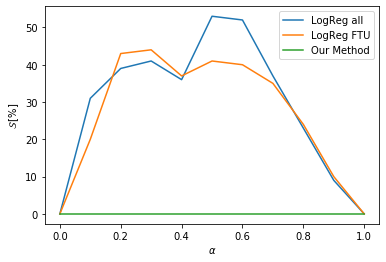

In [294]:
alpha = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.plot(alpha, counter_LR_ALL, label='LogReg all')
plt.plot(alpha, counter_LR_FTU, label='LogReg FTU')
plt.plot(alpha, counter_OUR_METHOD, label='Our Method')
plt.legend(loc="upper right")
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{S}\,[\%]$');
#tikzplotlib.save('S_over_alpha.tex')